In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import PolynomialFeatures

import pymc as pm
import xarray as xr
import arviz as az
from patsy import dmatrix
from pymc.sampling_jax import sample_blackjax_nuts

from numba import jit
@jit(nopython=True)  # Specify nopython=True to explicitly enable nopython mode
def my_function():
    # Your function code here
    pass

### Load Data

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Leipzig/Divergenz_Projekt/Divergenzindikatoren.xlsx', sheet_name='StandardabweichungenSkaliert')

In [2]:
df_q = pd.read_excel('/content/drive/MyDrive/Leipzig/Divergenz_Projekt/Index_Q.xlsx', sheet_name='Scaled Deviations')

### Yearly

In [5]:
df_new = df[['Year',
             'Mittelwert ohne Wechselkurs Lohn',
             'ECB Balance Sheet'
             ]]
df_new = df_new.rename(columns={'Mittelwert ohne Wechselkurs Lohn': 'Indicator'})

In [ ]:
fig = go.Figure()

# Add the first set of data (Mittelwert ohne Wechselkurs Lohn) to the figure
fig.add_trace(go.Scatter(x=df_new['Year'], y=df_new['Indicator'],
                         mode='lines', name='Divergenzindikator'))

# Add the second set of data (CB Balance Sheet) to the figure with a secondary y-axis
fig.add_trace(go.Scatter(x=df_new['Year'], y=df_new['ECB Balance Sheet'],
                         mode='lines', name='ECB Balance Sheet', yaxis='y2'))

# Update layout to show the second y-axis
fig.update_layout(title='Indicator vs. Balance Sheet Size',
                  yaxis=dict(title='Divergency Indicator'),
                  yaxis2=dict(title='ECB Balance Sheet', overlaying='y', side='right'),
                  width=1000)

fig.show()

In [ ]:
# We lotransform our data
df_log = df_new.copy()  # Create a copy of the DataFrame to avoid modifying the original data
df_log['Indicator'] = df_log['Indicator'] * 100
df_log[['Indicator', 'ECB Balance Sheet']] = df_log[['Indicator', 'ECB Balance Sheet']].apply(np.log)
df_log.head()

,Year,Indicator,ECB Balance Sheet
0,1999,2.025523,13.600897
1,2000,2.469669,13.636477
2,2001,2.317399,13.609825
3,2002,2.807422,13.586300
4,2003,2.671109,13.634943


Let's look at the logs

In [ ]:
fig = go.Figure()

# Add the first set of data (Mittelwert ohne Wechselkurs Lohn) to the figure
fig.add_trace(go.Scatter(x=df_log['Year'], y=df_log['Indicator'],
                         mode='lines', name='Divergenzindikator'))

# Add the second set of data (CB Balance Sheet) to the figure with a secondary y-axis
fig.add_trace(go.Scatter(x=df_log['Year'], y=df_log['ECB Balance Sheet'],
                         mode='lines', name='ECB Balance Sheet', yaxis='y2'))

# Update layout to show the second y-axis
fig.update_layout(title='Log Indicator vs. Balance Sheet',
                  yaxis=dict(title='Divergency Indicator'),
                  yaxis2=dict(title='ECB Balance Sheet', overlaying='y', side='right'),
                  width=1000)

fig.show()

Looks like there's some non-linearity in these curves, so let's check the polynomials

In [ ]:
coefficients = np.polyfit(df_log['Indicator'], df_log['ECB Balance Sheet'], deg=2)
polynomial = np.poly1d(coefficients)

# Generate points along the curve for plotting
x_values = np.linspace(df_log['Indicator'].min(), df_log['Indicator'].max(), 100)
y_values = polynomial(x_values)

# Plot the scatter plot with the polynomial curve
fig = px.scatter(df_log, x='Indicator', y='ECB Balance Sheet',
                 title='Scatter Plot with Polynomial Curve Fit',
                 width=1000)
fig.add_scatter(x=x_values, y=y_values, mode='lines', name='Polynomial')
fig.show()

Nice! Let's do a polynomial regression

In [ ]:
X = df_log['Indicator'].values.reshape(-1, 1)  # Reshape X to 2D array
y = df_log['ECB Balance Sheet']

# Generate polynomial features
poly = PolynomialFeatures(degree=2)  # Specify the degree of the polynomial
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
model = sm.OLS(y, X_poly).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      ECB Balance Sheet   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     54.04
Date:                Thu, 28 Mar 2024   Prob (F-statistic):           5.24e-09
Time:                        17:23:52   Log-Likelihood:                -5.6289
No. Observations:                  24   AIC:                             17.26
Df Residuals:                      21   BIC:                             20.79
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.5117      1.985      7.816      0.0

In [ ]:
residuals = model.resid

# Test for normality (Jarque-Bera test)
_, p_value_normality, _, _ = sm.stats.jarque_bera(residuals)
print(f'Jarque-Bera test p-value for normality: {p_value_normality}')
if p_value_normality < 0.05:
    print('The residuals do not follow a normal distribution.')
else:
  print('The residuals follow a normal distribution.')

X_with_const = sm.add_constant(X)
# Test for heteroskedasticity (Breusch-Pagan test)
_, p_value_hetero, _, _ = sm.stats.diagnostic.het_breuschpagan(residuals, X_with_const)
print(f'Breusch-Pagan test p-value for heteroskedasticity: {p_value_hetero}')
if p_value_hetero < 0.05:
    print('The residuals exhibit heteroskedasticity.')
else:
   print('The residuals do not exhibit heteroskedasticity.')

# Test for autocorrelation (Durbin-Watson test)
dw_statistic = sm.stats.stattools.durbin_watson(residuals)
print(f'Durbin-Watson statistic for autocorrelation: {dw_statistic}')
if dw_statistic < 1.5 or dw_statistic > 2.5:
    print('There may be autocorrelation in the residuals.')
else:
   print('There is no autocorrelation in the residuals.')

Jarque-Bera test p-value for normality: 0.5769170402744956
The residuals follow a normal distribution.
Breusch-Pagan test p-value for heteroskedasticity: 0.035249851384958265
The residuals exhibit heteroskedasticity.
Durbin-Watson statistic for autocorrelation: 1.4659398337757508
There may be autocorrelation in the residuals.


Our data is not correctly specified for this type of regression. 😞

### Let's be more Bayesian

In [ ]:
df_log.head()

,Year,Indicator,ECB Balance Sheet
0,1999,2.025523,13.600897
1,2000,2.469669,13.636477
2,2001,2.317399,13.609825
3,2002,2.807422,13.586300
4,2003,2.671109,13.634943


In [ ]:
x = df_log['Indicator'].values
y = df_log['ECB Balance Sheet'].values

# Normalizing x
x = (x - np.mean(x)) / np.std(x)

# Adding polynomial features
x_poly = np.stack([x, x**2], axis=1)

In [ ]:
with pm.Model() as model:
    # Priors
    α = pm.Normal('α', mu=0, sigma=2)
    β = pm.Normal('β', mu=0, sigma=2, shape=2)
    σ = pm.HalfNormal('σ', sigma=1)

    # Model
    μ = α + pm.math.dot(x_poly, β)

    # Likelihood
    y_obs = pm.StudentT('y_obs', mu=μ, nu= 3, sigma=σ, observed=y) # likelihood term following a StudentT distribution with v= 3 degrees of freedom

In [ ]:
with model:
    trace = pm.sample(2000, tune=1000, cores=1)

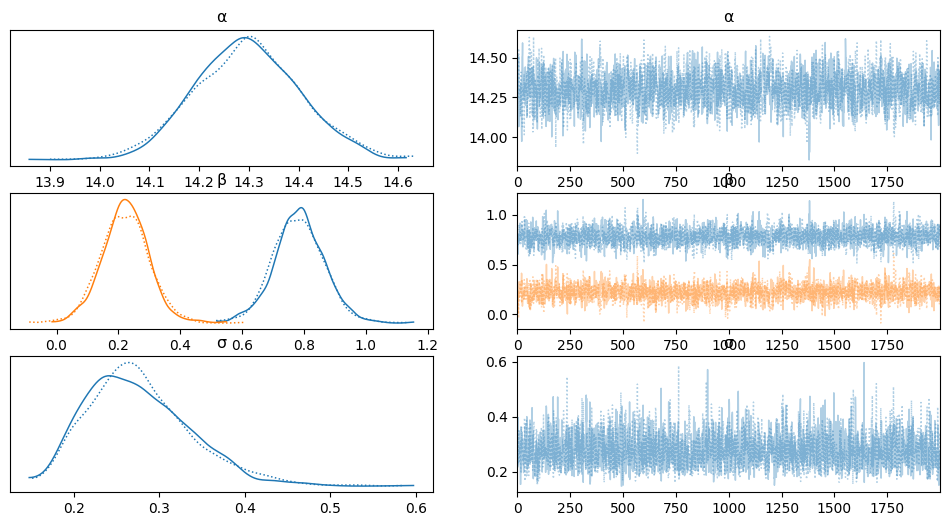

In [ ]:
az.plot_trace(trace);

In [ ]:
pm.summary(trace).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,14.30,0.11,14.11,14.51,0.0,0.0,1897.0,2545.0,1.0
β[0],0.78,0.08,0.63,0.95,0.0,0.0,2382.0,2190.0,1.0
β[1],0.22,0.08,0.07,0.36,0.0,0.0,1788.0,2045.0,1.0
σ,0.28,0.06,0.17,0.39,0.0,0.0,2483.0,2144.0,1.0


α (Intercept): This parameter represents the baseline level of the 'ECB Balance Sheet' when the normalized 'Indicator' (and its square) is at 0. The estimated mean value provides the expected value of the 'ECB Balance Sheet' in this baseline scenario.

β[0] (Linear Term): With a mean of 0.78, this coefficient indicates a positive linear relationship between the 'Indicator' and the 'ECB Balance Sheet'. Given its 95% HDI from 0.63 to 0.95, we're quite confident that this positive relationship is substantial, suggesting that as the 'Indicator' increases, the 'ECB Balance Sheet' also tends to increase linearly.

β[1] (Squared Term): The coefficient for the squared term of the 'Indicator' has a mean of 0.2, with a 95% HDI from 0.05 to 0.35. This indicates a positive but less pronounced non-linear relationship. The presence of this term suggests that the relationship between the 'Indicator' and the 'ECB Balance Sheet' may accelerate or decelerate beyond what a simple linear model would predict.

σ (Model Error): The standard deviation of the model's errors. The estimate shows the typical deviation of the observed 'ECB Balance Sheet' values from those predicted by the model, considering both linear and non-linear effects of the 'Indicator'.


In [ ]:
post = az.extract(trace, num_samples=20)

fig = go.Figure(go.Scatter(x=x, y=y, mode='markers', name='Observed data', marker=dict(color='blue')))

# Loop through each set of β samples
for i in range(post['β'].shape[1]):
    α_sample = float(post['α'][i])  # Convert to float

    # Ensure β_sample is a numpy array
    β_sample = np.asarray(post['β'][:, i])  # Convert to numpy array if it's not already

    # Generate x values
    x_values = np.linspace(min(x), max(x), 100)
    x_poly_values = np.stack([x_values, x_values**2], axis=1)

    # Calculate y_pred for the current set of parameters
    y_pred = α_sample + np.dot(x_poly_values, β_sample)

    # Add a line plot for the current set of predicted values
    fig.add_trace(go.Scatter(x=x_values, y=y_pred, mode='lines', opacity=0.2,
                             line=dict(color='red', width=1)))
    fig.add_scatter(x=x_values, y=y_values, mode='lines', name='Polynomial',
                             line=dict(color='green', width=2))

# Add titles and labels
fig.update_layout(title='Posterior predictive for Student-T likelihood',
                  xaxis_title='Indicator',
                  yaxis_title='ECB Balance Sheet',
                  legend_title="Legend",
                  showlegend=False,
                  width=1000)

The fit is slightly skewed, which means that there is some amount of uncertainty in our estimate. However, the effect of the outliers is far smaller than under normal distribution.

### Quarterly Scaling

In [ ]:
df_q.index = df_q['Unnamed: 0']
df_q.drop(columns=['Unnamed: 0'], inplace=True)
df_q.index = pd.to_datetime(df_q.index).strftime('%Y%m%d')

In [ ]:
df_q

,Inflation Standard Dev,Wage Growth Standard Dev,Gdp per Capita Standard Dev,Real Growth Std,Debt to GDP Std,Balance of Trade Std,Real Ex Rates Std
Unnamed: 0,,,,,,,
19990101,3.506366,3.626204,7655.304137,1.641784,32.269035,NaN,0.000000
19990401,3.455755,3.606066,8172.895110,0.594868,32.542816,NaN,0.478462
19990701,3.381522,3.684097,8624.630812,0.971130,32.743164,NaN,0.640047
19991001,3.332641,3.513877,8677.955550,0.691722,30.372877,NaN,1.114337
20000101,3.309209,3.336747,9436.432341,1.346273,29.723081,5.734541e+05,1.273063
...,...,...,...,...,...,...,...
20221001,10.435568,6.781972,31168.127177,0.897796,41.141134,1.197583e+06,17.084689
20230101,11.076449,3.965137,29988.220073,0.853722,40.504366,1.290111e+06,17.642918
20230401,11.006446,3.627231,29527.307317,0.818381,39.394083,1.114721e+06,17.082359


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from sklearn.base import TransformerMixin

class PositiveMinMaxScaler(TransformerMixin):
    def __init__(self):
        self.min_ = None
        self.scale_ = None

    def fit(self, X):
        self.min_ = X.min()
        self.scale_ = 1 / (X.max() - self.min_)
        return self

    def transform(self, X):
        X_scaled = (X - self.min_) * self.scale_
        return X_scaled

# Assuming df_q is your DataFrame
# Initialize PositiveMinMaxScaler
scaler = PositiveMinMaxScaler()

# Fit and transform the DataFrame
scaled_df = scaler.fit_transform(df_q)

# Convert the scaled numpy array back to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=df_q.columns)


In [ ]:
scaled_df.to_excel('/content/drive/MyDrive/Leipzig/Divergenz_Projekt/Scaled_Deviations.xlsx')

### Quarterly Regressions

In [6]:
df_q.index = df_q['Unnamed: 0']
df_q.drop(columns=['Unnamed: 0', 'Unnamed: 8', 'Unnamed: 10'], inplace=True)
df_q.index = pd.to_datetime(df_q.index).strftime('%Y-%m-%d')

In [7]:
df_q_new = df_q.iloc[:-1,-3:-1]

In [8]:
df_q_new[['Indicator', 'ECB Balance Sheet']] = df_q_new[['Indicator', 'ECB Balance Sheet',]]

In [9]:
df_q_new

,Indicator,ECB Balance Sheet
Unnamed: 0,,
1999-01-01,0.171682,0.687120
1999-04-01,0.144110,0.701245
1999-07-01,0.164144,0.723853
1999-10-01,0.136393,0.743958
2000-01-01,0.133889,0.762059
...,...,...
2022-10-01,0.743991,8.556305
2023-01-01,0.702772,7.870104
2023-04-01,0.644150,7.680812


Let's smoothe our data for visualization only.

In [ ]:
lambda_hp = 4
indicator_cycle, indicator_trend = sm.tsa.filters.hpfilter(df_q_new['Indicator'], lamb=lambda_hp)

# You might want to add the trend and cycle back to your DataFrame
df_q_new['Indicator_Trend'] = indicator_trend

fig = go.Figure()

# Add the first set of data (Mittelwert ohne Wechselkurs Lohn) to the figure
fig.add_trace(go.Scatter(x=df_q_new.index, y=df_q_new['Indicator_Trend'],
                         mode='lines', name='Divergenzindikator'))

# Add the second set of data (CB Balance Sheet) to the figure with a secondary y-axis
fig.add_trace(go.Scatter(x=df_q_new.index, y=df_q_new['ECB Balance Sheet'],
                         mode='lines', name='ECB Balance Sheet', yaxis='y2'))

# Update layout to show the second y-axis
fig.update_layout(title='Indicator vs. Balance Sheet',
                  xaxis=dict(title='Year'),
                  yaxis=dict(title='Divergency Indicator'),
                  yaxis2=dict(title='ECB Balance Sheet', overlaying='y', side='right'),
                  width=1000)

fig.show()

In [ ]:
df_q_new.to_excel('/content/drive/MyDrive/Leipzig/Divergenz_Projekt/Index_Trend.xlsx')

As in the yearly data, we can clearly observe the polynomial trend.

In [32]:
# You might want to add the trend and cycle back to your DataFrame
coefficients = np.polyfit(df_q_new['Indicator'], df_q_new['ECB Balance Sheet'], deg=2)
polynomial = np.poly1d(coefficients)

# Generate points along the curve for plotting
x_values = np.linspace(df_q_new['Indicator'].min(), df_q_new['Indicator'].max(), 100)
y_values = polynomial(x_values)

# Plot the scatter plot with the polynomial curve
fig = px.scatter(df_q_new, x='Indicator', y='ECB Balance Sheet',
                 title='Scatter Plot with Polynomial Curve Fit',
                 width=1000)
fig.add_scatter(x=x_values, y=y_values, mode='lines', name='Polynomial Curve Fit')
fig.show()

### Polynomial Bayesian Regression

In [10]:
df_q_new['Indicator'].describe()

count    100.000000
mean       0.357818
std        0.165135
min        0.121432
25%        0.209900
50%        0.362275
75%        0.425065
max        0.743991
Name: Indicator, dtype: float64

In [11]:
df_q_new['ECB Balance Sheet'].describe()

count    100.000000
mean       2.877488
std        2.361414
min        0.687120
25%        0.925552
50%        2.032493
75%        4.306059
max        8.801323
Name: ECB Balance Sheet, dtype: float64

In [12]:
x = df_q_new['Indicator'].values
y = df_q_new['ECB Balance Sheet'].values

x = (x - np.mean(x)) / np.std(x) # We standardize
y = (y - np.mean(y)) / np.std(y)

# Adding polynomial features
x_poly = np.stack([x, x**2], axis=1)

In [14]:
with pm.Model() as model:
    # Priors
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=1, shape=2)
    σ = pm.HalfNormal('σ', sigma=1)

    # Model
    μ = α + pm.math.dot(x_poly, β)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=μ, sigma=σ, observed=y)

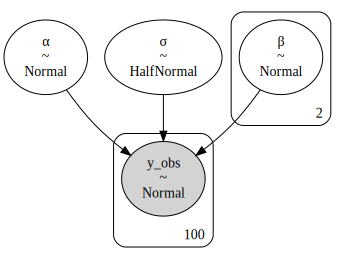

In [15]:
pm.model_to_graphviz(model)

In [16]:
with model:
    trace = pm.sample(1000, tune=500, cores=1)

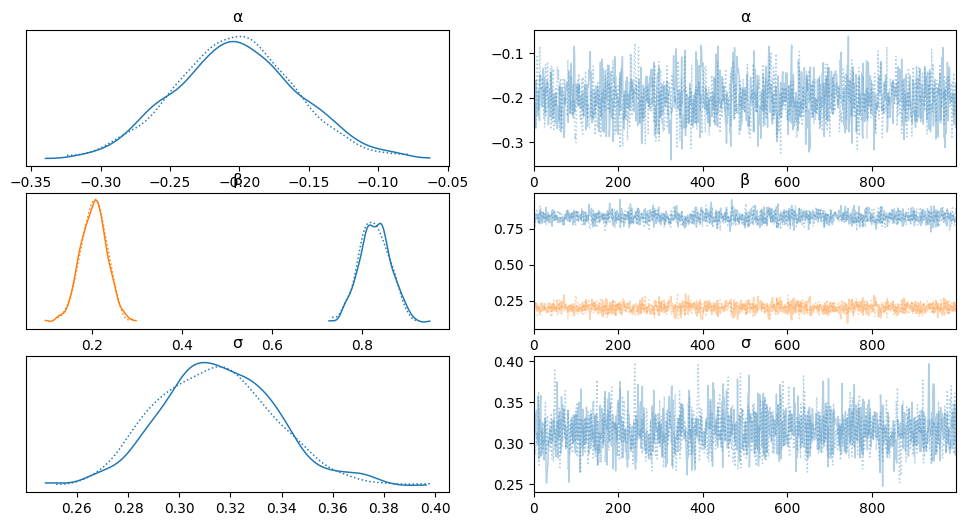

In [18]:
az.plot_trace(trace);

In [20]:
pm.summary(trace).round(4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.203,0.044,-0.282,-0.118,0.001,0.001,1154.0,1464.0,1.0
β[0],0.829,0.034,0.764,0.892,0.001,0.001,1393.0,1303.0,1.0
β[1],0.204,0.029,0.149,0.257,0.001,0.001,1098.0,1256.0,1.0
σ,0.315,0.022,0.268,0.353,0.001,0.000,1309.0,1340.0,1.0


Intercept (α)
The intercept, α, is the expected value of y when all predictors (x and x^2) are at their mean. The negative mean value of the intercept suggests that, when the Indicator variable is at its average level, the ECB Balance Sheet is expected to be lower than its mean. The HDI shows that there's a 94% probability that the true value of α lies between -0.28 and -0.12, indicating a fairly tight confidence around the mean estimate.

Coefficients (β)
Both coefficients for the linear (β[0]) and squared (β[1]) terms are positive, with their HDIs confidently above 0, indicating a positive relationship with the ECB Balance Sheet. Specifically, as the normalized Indicator increases, both linearly and in terms of its square, the ECB Balance Sheet is expected to increase. The positive coefficient for the squared term indicates a nonlinear (quadratic) relationship, suggesting that as the Indicator moves away from its mean, the ECB Balance Sheet is expected to increase more significantly than what would be expected from a linear relationship alone.

Standard Deviation of Observations (σ)
The standard deviation parameter, σ, reflects the variability of the observed ECB Balance Sheet values around the model's predicted values. A mean of 0.31 with a relatively narrow HDI indicates that the residuals of the model (the differences between observed and predicted y values) are moderately spread out, but not excessively so.

Overall Interpretation
The positive and statistically significant estimates for both linear and quadratic terms of "Indicator" suggest that the relationship between "Indicator" and the "ECB Balance Sheet" is both direct and nonlinear. Specifically, as the "Indicator" increases, the "ECB Balance Sheet" is expected to increase at an accelerating rate.

In [34]:
post = az.extract(trace, num_samples=20)

fig = go.Figure(go.Scatter(x=x, y=y, mode='markers', name='Observed data', marker=dict(color='blue')))

# Loop through each set of β samples
for i in range(post['β'].shape[1]):
    α_sample = float(post['α'][i])  # Convert to float

    # Ensure β_sample is a numpy array
    β_sample = np.asarray(post['β'][:, i])  # Convert to numpy array if it's not already

    # Generate x values
    x_values = np.linspace(min(x), max(x),100)
    x_poly_values = np.stack([x_values, x_values**2.0], axis=1)

    # Calculate y_pred for the current set of parameters
    y_pred = α_sample + np.dot(x_poly_values, β_sample)

    # Add a line plot for the current set of predicted values
    fig.add_trace(go.Scatter(x=x_values, y=y_pred, mode='lines', opacity=0.2,
                             line=dict(color='red', width=1)))
    #fig.add_scatter(x=x_values, y=y_values, mode='lines', name='Polynomial',
    #                        line=dict(color='green', width=2))

# Add titles and labels
fig.update_layout(title='Posterior predictive likelihood',
                  xaxis_title='Indicator',
                  yaxis_title='ECB Balance Sheet',
                  legend_title="Legend",
                  showlegend=False,
                  width=1000)

In [50]:
with model:
    # Posterior predictive checks
    posterior_predictive = pm.sample_posterior_predictive(trace)
    bayesian_r2 = pm.stats.r2_score(y, posterior_predictive.posterior_predictive['y_obs'][1].values)

print(f"Bayesian R^2: {bayesian_r2.iloc[0]}")

Bayesian R^2: 0.8376690777535709


In [38]:
predicted_y_samples = posterior_predictive.posterior_predictive["y_obs"].values
predicted_y_samples_flattened = predicted_y_samples.reshape(-1, predicted_y_samples.shape[-1])

observed_y = y
x_index = np.arange(len(observed_y))


fig = go.Figure()

# Add observed data as scatter plot
fig.add_trace(go.Scatter(x=x_index, y=observed_y, mode='markers', name='Observed y', marker=dict(color='blue', size=10, opacity=0.5)))

# Add violin plots for predictive samples
for i in range(predicted_y_samples_flattened.shape[1]):
    fig.add_trace(go.Violin(y=predicted_y_samples_flattened[:, i], x=np.full(predicted_y_samples_flattened.shape[0], i), side='positive', name='Predictive y_obs', line_color='lightgrey'))

# Updating the layout for a cleaner look
fig.update_layout(violingap=0, violinmode='overlay')
fig.update_layout(title='Observed vs. Predictive Samples of y_obs', xaxis_title='Index', yaxis_title='y and Predictive y_obs', legend_title='Legend')

# Show plot
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Great, our model's predictions are consistent with the observed data and capable of capturing the underlying distribution of the observed data.

#### Compute estimates

In [ ]:
alpha = -0.203
beta_0 = 0.829
beta_1 = 0.203

# Generate a range of standardized 'Indicator' values
x_range_1 = np.linspace(0.6, 1, 100)
x_range_2 = np.linspace(0.6, 2, 100)
x_range_3 = np.linspace(0.6, 3, 100)
x_range_4 = np.linspace(0.6, 4, 100)

# Compute predicted 'ECB Balance Sheet' values using the polynomial model
df_q_new['predicted_ecb_1'] = alpha + beta_0 * x_range_1 + beta_1 * x_range_1**2
df_q_new['predicted_ecb_2'] = alpha + beta_0 * x_range_2 + beta_1 * x_range_2**2
df_q_new['predicted_ecb_3'] = alpha + beta_0 * x_range_3 + beta_1 * x_range_3**2
df_q_new['predicted_ecb_4'] = alpha + beta_0 * x_range_4 + beta_1 * x_range_4**2

trace1 = go.Scatter(x=df_q_new.index, y=df_q_new['predicted_ecb_1'], mode='lines', name='Range 0-1')
trace2 = go.Scatter(x=df_q_new.index, y=df_q_new['predicted_ecb_2'], mode='lines', name='Range 0-2')
trace3 = go.Scatter(x=df_q_new.index, y=df_q_new['predicted_ecb_3'], mode='lines', name='Range 0-3')
trace4 = go.Scatter(x=df_q_new.index, y=df_q_new['predicted_ecb_4'] , mode='lines', name='Range 0-4')

# Create layout
layout = go.Layout(title='Predicted ECB Balance Sheet',
                   xaxis=dict(title='Indicator'),
                   yaxis=dict(title='ECB Balance Sheet'))

# Create figure
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)

# Display the figure
fig.show()

In [ ]:
df_q_new.to_excel('/content/drive/MyDrive/Leipzig/Divergenz_Projekt/Poly_estimates.xlsx')

In [ ]:
# Let's get some more info on these estimates

df_q_new.index = pd.to_datetime(df_q_new.index)

growth_rates = df_q_new['predicted_ecb_2'] / df_q_new['predicted_ecb_2'].shift(4) - 1

# Drop the NaN values resulting from the shift operation
growth_rates = growth_rates.dropna()

# Calculate the average growth rate
average_growth_rate = growth_rates.mean()

print("Average Growth Rate from One Year Ago:", average_growth_rate)

Average Growth Rate from One Year Ago: 0.07585071801324118


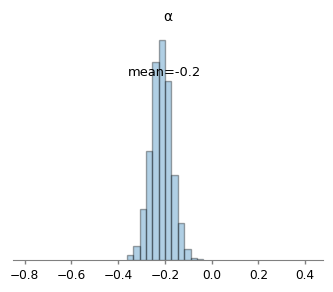

In [ ]:
ax = az.plot_posterior(
    trace,
    var_names="α",
    hdi_prob="hide",
    point_estimate="mean",
    kind="hist",
    ec="black",
    figsize=(4, 3),
)

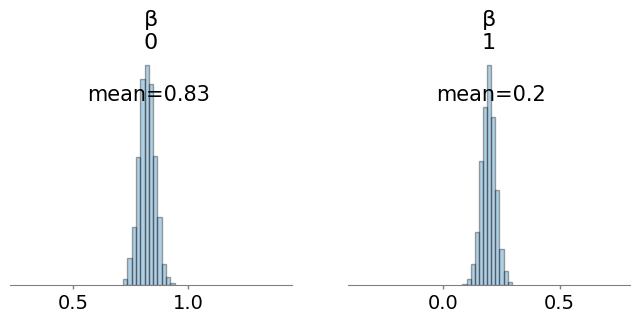

In [ ]:
ax = az.plot_posterior(
    trace,
    var_names="β",
    hdi_prob="hide",
    point_estimate="mean",
    kind="hist",
    ec="black",
    figsize=(8, 3),
)

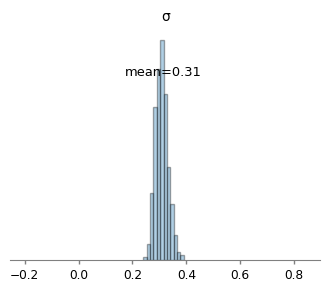

In [ ]:
ax = az.plot_posterior(
    trace,
    var_names="σ",
    hdi_prob="hide",
    point_estimate="mean",
    kind="hist",
    ec="black",
    figsize=(4, 3),
)

### Bayesian Structural Model

In [ ]:
!pip install pybuc # restart session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 806.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.5/819.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.1/777.1 kB 43.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall:

In [2]:
from pybuc import buc

from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.graphics.tsaplots import plot_acf

In [104]:
df_q = pd.read_excel('/content/drive/MyDrive/Leipzig/Divergenz_Projekt/Index_Q.xlsx', sheet_name='Scaled Deviations')

In [105]:
df_q.index = df_q['Unnamed: 0']
df_q.drop(columns=['Unnamed: 0', 'Unnamed: 8', 'Unnamed: 10'], inplace=True)
df_q.index = pd.to_datetime(df_q.index).strftime('%Y-%m-%d')

df_q_new = df_q.iloc[:-1,-3:]

df_q_new = df_q_new[['Indicator', 'ECB Balance Sheet', 'Shadow Rate']]

In [106]:
df_q_new.index = pd.to_datetime(df_q_new.index)

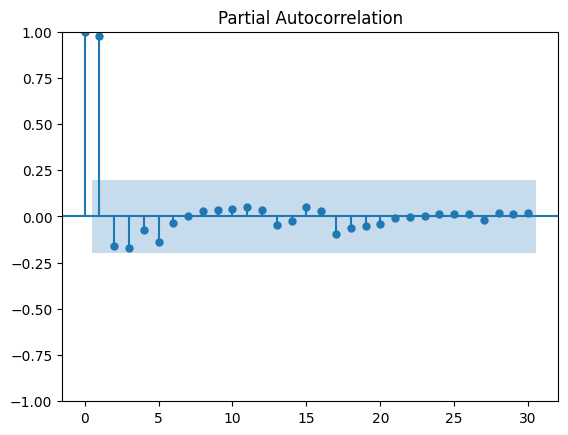

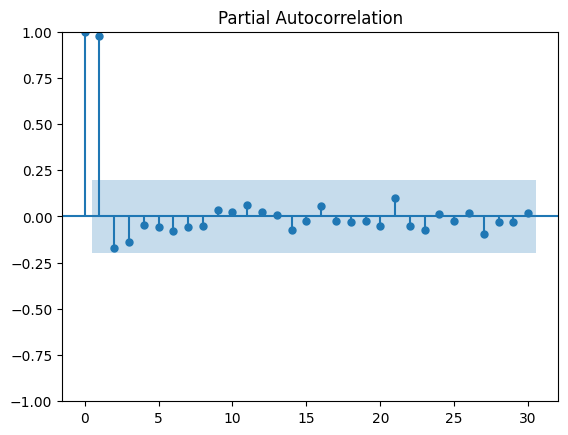

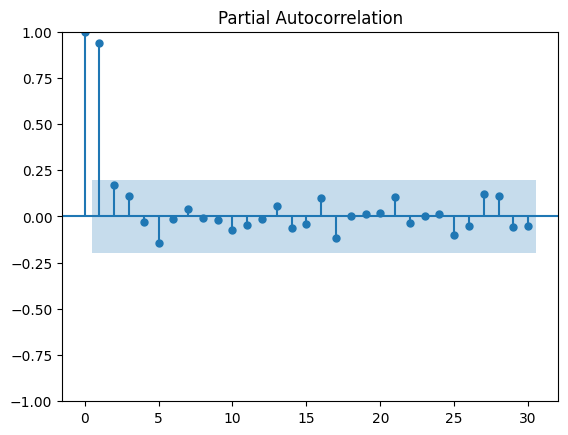

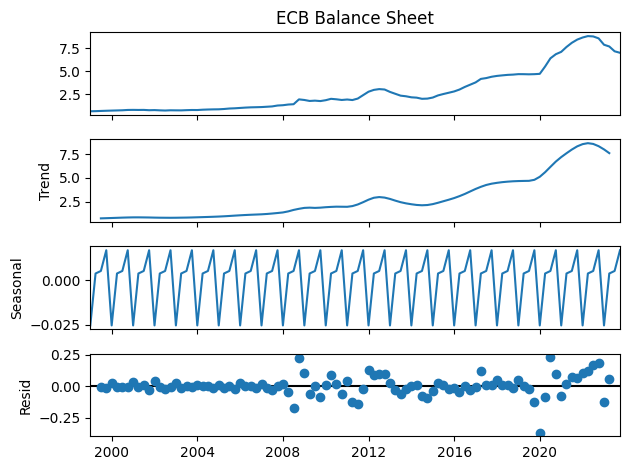

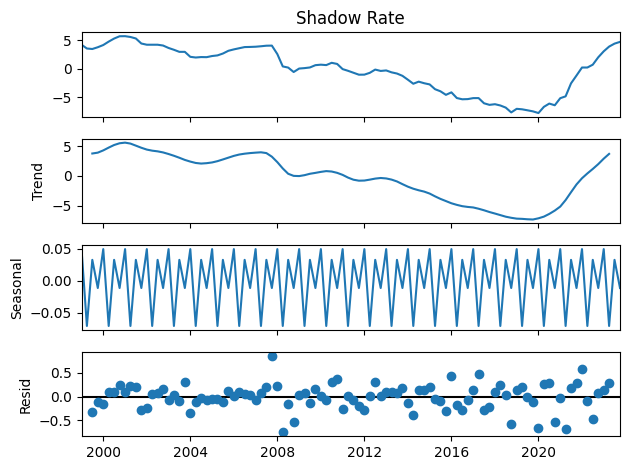

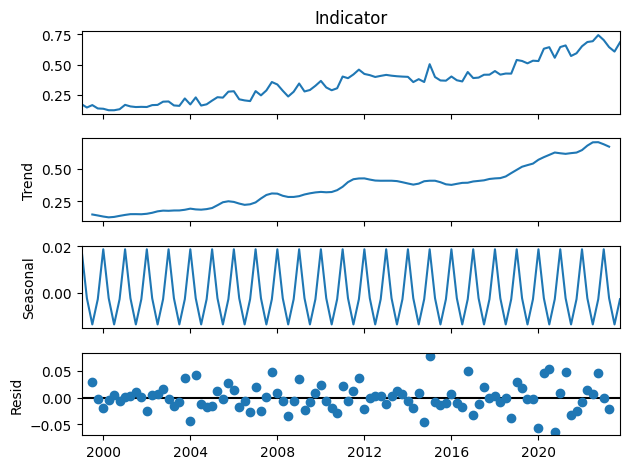

In [103]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

'''
plot_acf(df_q_new['ECB Balance Sheet'], lags=50)
plt.show()
plot_acf(df_q_new['Shadow Rate'], lags=50)
plt.show()
plot_acf(df_q_new['Indicator'], lags=50)
plt.show()
'''
plot_pacf(df_q_new['ECB Balance Sheet'], lags=30)
plt.show()
plot_pacf(df_q_new['Shadow Rate'], lags=30)
plt.show()
plot_pacf(df_q_new['Indicator'], lags=30)
plt.show()

# Decompose time series
result_1 = seasonal_decompose(df_q_new['ECB Balance Sheet'], model='additive')
result_2 = seasonal_decompose(df_q_new['Shadow Rate'], model='additive')
result_3 = seasonal_decompose(df_q_new['Indicator'], model='additive')

# Plot
result_1.plot()
plt.show()
result_2.plot()
plt.show()
result_3.plot()
plt.show()

We have partial auto-correlation on lags 1 and 2. We have seasonal compenents after 8 and 12 periods.

In [107]:
#Let's incorporate 2 lags
for lag in range(1, 3):
    df_q_new[f'ECB Balance Sheet Lag {lag}'] = df_q_new['ECB Balance Sheet'].shift(lag)
    df_q_new[f'Shadow Rate Lag {lag}'] = df_q_new['Shadow Rate'].shift(lag)

df_q_new.dropna(inplace=True)

In [80]:
df_q_new.head()

,Indicator,ECB Balance Sheet,Shadow Rate,ECB Balance Sheet Lag 1,Shadow Rate Lag 1,ECB Balance Sheet Lag 2,Shadow Rate Lag 2
Unnamed: 0,,,,,,,
1999-07-01,0.164144,0.723853,3.500000,0.701245,3.587912,0.687120,4.250000
1999-10-01,0.136393,0.743958,3.809783,0.723853,3.500000,0.701245,3.587912
2000-01-01,0.133889,0.762059,4.197802,0.743958,3.809783,0.723853,3.500000
2000-04-01,0.121537,0.778062,4.796703,0.762059,4.197802,0.743958,3.809783
2000-07-01,0.121432,0.795922,5.331522,0.778062,4.796703,0.762059,4.197802


In [110]:
hold_out_size = 4

# Prepare the target and features for the training dataset
y_train = df_q_new.iloc[:-hold_out_size]['Indicator']
X_train = df_q_new.iloc[:-hold_out_size].drop('Indicator', axis=1)

# Prepare the target and features for the testing dataset
y_test = df_q_new.iloc[-hold_out_size:]['Indicator']
X_test = df_q_new.iloc[-hold_out_size:].drop('Indicator', axis=1)

# Fit the Bayesian Unobserved Components model
bayes_uc = buc.BayesianUnobservedComponents(y_train,
                                            predictors=X_train,
                                            level=True, stochastic_level=False,
                                            trend=True, stochastic_trend=False,
                                            #lag_seasonal=(2,4),
                                            #stochastic_lag_seasonal=(True,True),
                                            seed=42)
post = bayes_uc.sample(1000)
mcmc_burn = 100

/usr/local/lib/python3.10/dist-packages/pybuc/buc.py:483: UserWarning: Frequency of DatetimeIndex is None. Frequency will be inferred for response.
  warnings.warn('Frequency of DatetimeIndex is None. Frequency will be inferred '


In [111]:
# Print summary of estimated parameters
for key, value in bayes_uc.summary(burn=mcmc_burn).items():
    print(key, ' : ', value)

Number of posterior samples (after burn)  :  900
Posterior.Mean[Irregular.Var]  :  0.0006510826189149012
Posterior.StdDev[Irregular.Var]  :  0.000529572006929739
Posterior.CredInt.LB[Irregular.Var]  :  1.3764287334845192e-06
Posterior.CredInt.UB[Irregular.Var]  :  0.0016654450511548401
Posterior.Mean[Lag-Seasonal.2.Var]  :  0.0012136789476629856
Posterior.StdDev[Lag-Seasonal.2.Var]  :  0.0009414442329179014
Posterior.CredInt.LB[Lag-Seasonal.2.Var]  :  0.00013612363404798408
Posterior.CredInt.UB[Lag-Seasonal.2.Var]  :  0.0031582181939155993
Posterior.Mean[Lag-Seasonal.4.Var]  :  0.00021688585825054433
Posterior.StdDev[Lag-Seasonal.4.Var]  :  0.00017912352285097546
Posterior.CredInt.LB[Lag-Seasonal.4.Var]  :  5.024367580249399e-05
Posterior.CredInt.UB[Lag-Seasonal.4.Var]  :  0.0006082434073513517
Posterior.Mean[Coeff.ECB Balance Sheet]  :  0.11860023324839596
Posterior.StdDev[Coeff.ECB Balance Sheet]  :  0.03371742486620877
Posterior.CredInt.LB[Coeff.ECB Balance Sheet]  :  0.054201783215

In [112]:
ppd = bayes_uc.post_pred_dist()

# Extract relevant information
historical_time_index = bayes_uc.historical_time_index[bayes_uc.num_first_obs_ignore:]
cred_int_level = 0.05  # Change this if needed

# Calculate mean, lower bound, and upper bound
mean_ppd = np.mean(ppd, axis=0)
cred_int_lb = np.quantile(ppd, 0.5 * cred_int_level, axis=0)
cred_int_ub = np.quantile(ppd, 1. - 0.5 * cred_int_level, axis=0)

# Store in a DataFrame
df = pd.DataFrame({
    'Time Index': historical_time_index,
    'Mean': mean_ppd,
    'Lower Bound': cred_int_lb,
    'Upper Bound': cred_int_ub
})

df.head()

,Time Index,Mean,Lower Bound,Upper Bound
0,2001-10-01,0.147843,0.031354,0.267469
1,2002-01-01,0.179571,0.065800,0.301686
2,2002-04-01,0.144190,0.026652,0.264081
3,2002-07-01,0.129608,0.005311,0.246274
4,2002-10-01,0.160425,0.039266,0.276921


In [95]:
df.to_excel('/content/drive/MyDrive/Leipzig/Divergenz_Projekt/Estimates_Structural_Model.xlsx')

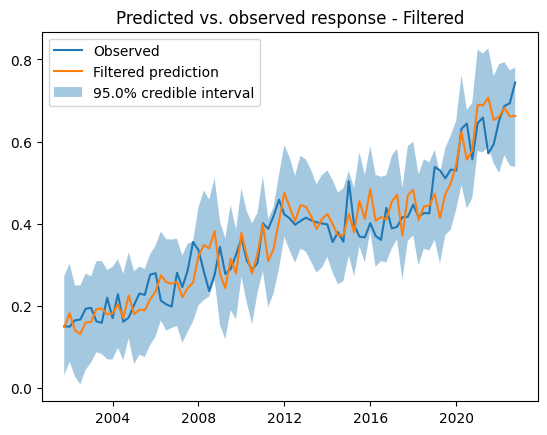

In [113]:
bayes_uc.plot_post_pred_dist(burn=mcmc_burn)

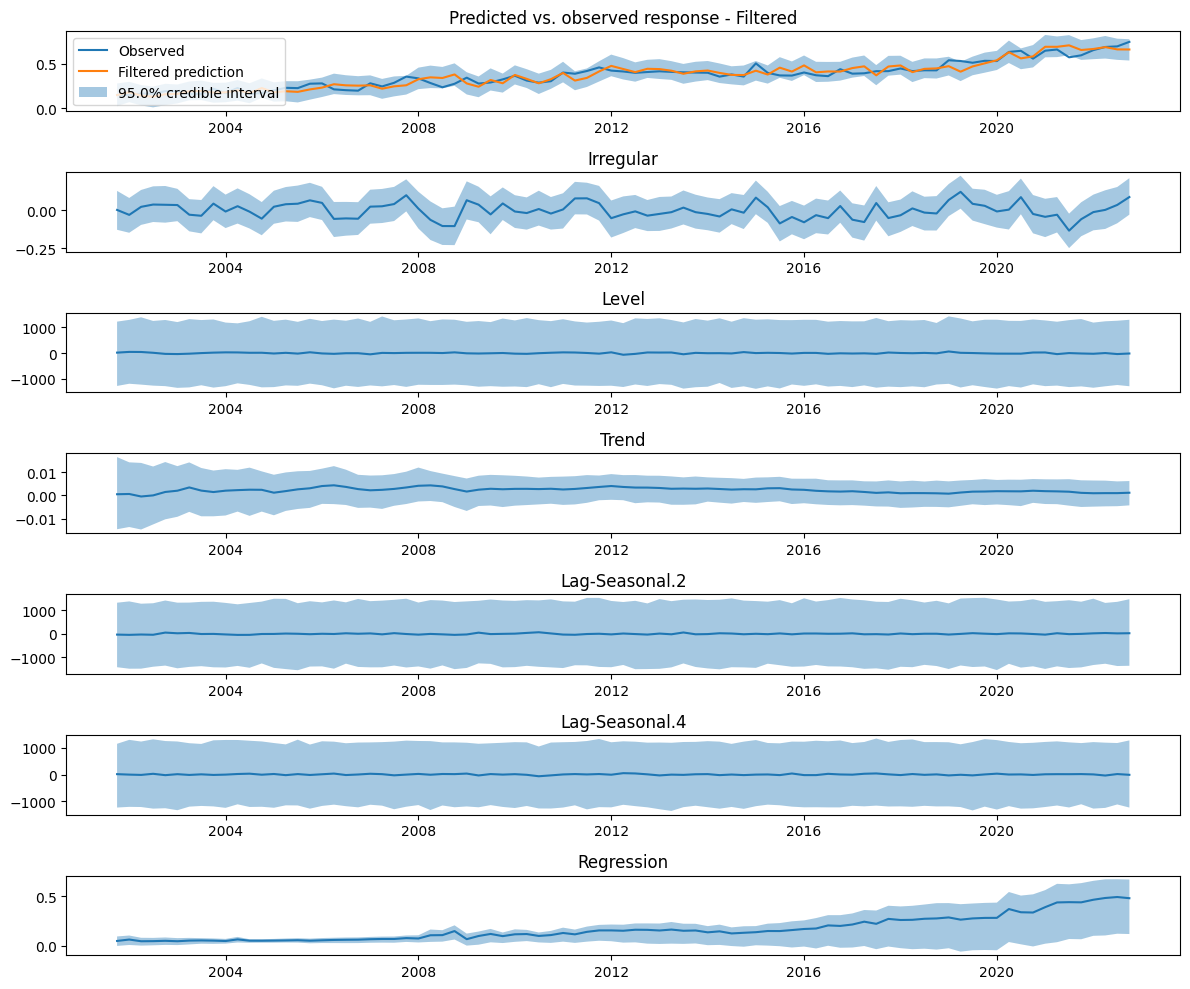

In [98]:
# Plot time series components
bayes_uc.plot_components(burn=mcmc_burn, smoothed=False)
plt.show()

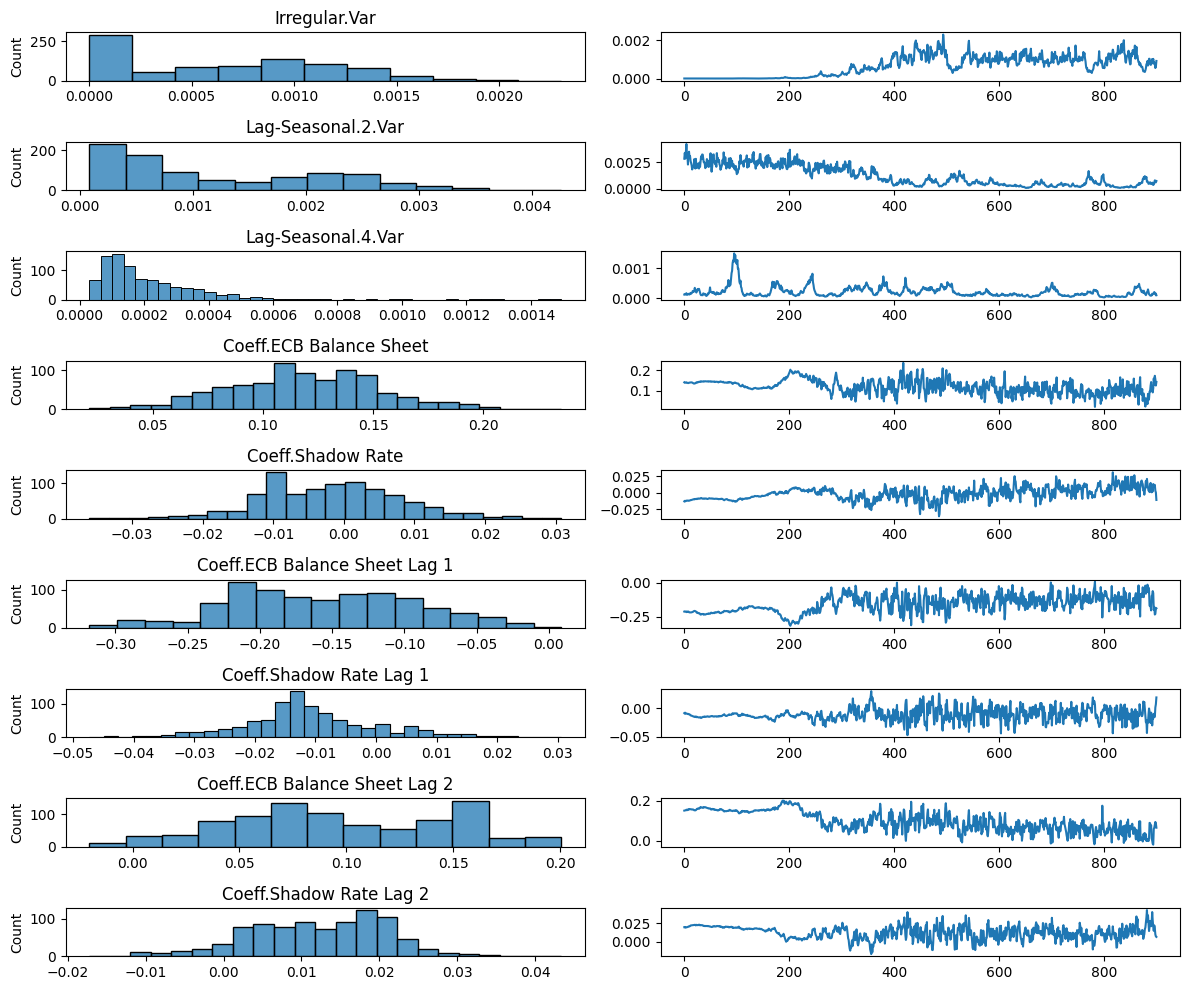

In [115]:
# Plot trace of posterior
bayes_uc.plot_trace(burn=mcmc_burn)
plt.show()

In [100]:
# Get and plot forecast
forecast, _ = bayes_uc.forecast(hold_out_size, mcmc_burn, future_predictors=X_test)
forecast_mean = np.mean(forecast, axis=0)
forecast_l95 = np.quantile(forecast, 0.025, axis=0).flatten()
forecast_u95 = np.quantile(forecast, 0.975, axis=0).flatten()

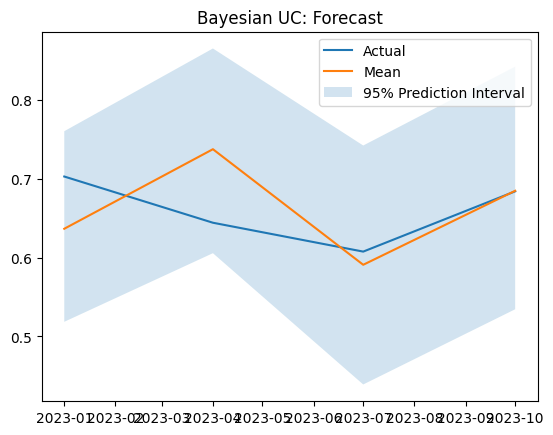

In [101]:
plt.plot(y_test)
plt.plot(bayes_uc.future_time_index, forecast_mean)
plt.fill_between(bayes_uc.future_time_index, forecast_l95, forecast_u95, alpha=0.2)
plt.title('Bayesian UC: Forecast')
plt.legend(['Actual', 'Mean', '95% Prediction Interval'])
plt.show()

In [102]:
# Print RMSE
def rmse(actual, prediction):
    act, pred = actual.flatten(), prediction.flatten()
    return np.sqrt(np.mean((act - pred) ** 2))

print(f"BAYES-UC RMSE: {rmse(y_test.to_numpy(), forecast_mean)}")

BAYES-UC RMSE: 0.05781297294280851
